# CS579: Lecture 15  

**More Classification**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

## Recall Error function for logistic regression.

Given labeled dataset $D=\{(x_1, y_1), \ldots (x_n, y_n)\}$

$$
E(D, \theta) = - \prod_{i \in D} p(y_i|x_i)
$$

$$
p(y_i|x_i) = \frac{1}{1 + e^{-y_i x_i \cdot \theta}}
$$

In [3]:
import numpy as np
import math

In [4]:
x = np.array([1,0,0,1])
theta = np.array([.9, -.9, .1, -.1])
x.dot(theta)
# E.g., 
# feature 0 (.9) is strongly predictive of y=1
# feature 1 (-.9) is strongly predictive of y=-1
# feature 2 (.1) is weakly predictive of y=1
# feature 3 (-.1) is weakly predictive of y=1

0.80000000000000004

In [5]:
def logistic(x, theta, y):
    return 1. / (1 + math.exp(-y * x.dot(theta)))

print('for x=', x)
print('p(y=1|x)=%.3g' % logistic(x, theta, 1.))
print('p(y=-1|x)=%.3g' % logistic(x, theta, -1.))

('for x=', array([1, 0, 0, 1]))
p(y=1|x)=0.69
p(y=-1|x)=0.31


In [6]:
x = np.array([1, 0, 1, 0])
print('for x=', x)
print('p(y=1|x)=%.3g' % logistic(x, theta, 1.))
print('p(y=0|x)=%.3g' % logistic(x, theta, -1.))

('for x=', array([1, 0, 1, 0]))
p(y=1|x)=0.731
p(y=0|x)=0.269


In [7]:
x = np.array([0, 1, 1, 0])
print('for x=', x)
print('p(y=1|x)=%.3g' % logistic(x, theta, 1.))
print('p(y=0|x)=%.3g' % logistic(x, theta, -1.))

('for x=', array([0, 1, 1, 0]))
p(y=1|x)=0.31
p(y=0|x)=0.69


In [8]:
def error(X, y, theta):
    error = 1.
    for xi, yi in zip(X, y):
        prob = logistic(xi, theta, yi)
        print('probability of %d for %s=%.3f' % (yi, str(xi), prob))
        error *= prob
    return -error

In [9]:
X = np.array([
  [1, 0, 0, 0],
  [1, 0, 1, 0],
  [0, 1, 0, 0],
  [0, 1, 0, 1],
])

y = np.array([
        1,
        1,
        -1,
        -1
    ])

In [10]:
print('error for theta=', theta)
error(X, y, theta)

('error for theta=', array([ 0.9, -0.9,  0.1, -0.1]))
probability of 1 for [1 0 0 0]=0.711
probability of 1 for [1 0 1 0]=0.731
probability of -1 for [0 1 0 0]=0.711
probability of -1 for [0 1 0 1]=0.731


-0.2701356268331891

In [11]:
# Make theta even better:
theta = np.array([10, -10, 10, -10])
error(X, y, theta)

probability of 1 for [1 0 0 0]=1.000
probability of 1 for [1 0 1 0]=1.000
probability of -1 for [0 1 0 0]=1.000
probability of -1 for [0 1 0 1]=1.000


-0.9999092022016287

In [12]:
# Make theta much, much worse:
theta = np.array([-10, 10, -10, 10])
error(X, y, theta)

probability of 1 for [1 0 0 0]=0.000
probability of 1 for [1 0 1 0]=0.000
probability of -1 for [0 1 0 0]=0.000
probability of -1 for [0 1 0 1]=0.000


-8.755715690797854e-27

In [13]:
# Make theta even better:
theta = np.array([100, -100, 100, -100])
error(X, y, theta)

probability of 1 for [1 0 0 0]=1.000
probability of 1 for [1 0 1 0]=1.000
probability of -1 for [0 1 0 0]=1.000
probability of -1 for [0 1 0 1]=1.000


-1.0

## Regularization

Controls how many parameters the model has, or how large each parameter can get.

E.g. L2 Regularization for linear regression:

$$
E(D, \theta) =  - \prod_{i \in D} p(y_i|x_i) + \frac{1}{C}||\vec{\theta}||^2_2
$$

$$
 =  - \prod_{i \in D} p(y_i|x_i) + \frac{1}{C}\sum_k \theta_k^2
$$

As $C \rightarrow 0$, the classifier prefers smaller and smaller coefficients.

This is the $C$ parameter of the `LogisticRegression` class in sklearn.



In [14]:
from collections import Counter
import glob
import hashlib
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tarfile
from urllib import urlretrieve
%matplotlib inline

In [15]:
def get_data():
    """ Download and unzip data."""
    urlretrieve('https://www.dropbox.com/s/xk4glpk61q3qrg2/imdb.tgz?dl=1', 'imdb.tgz')
    tar = tarfile.open("imdb.tgz")
    tar.extractall()
    tar.close()
    
get_data()

In [16]:
# Here is the path to the data directory.
path = 'data'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [17]:
def get_files(path):
    """ Return a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    ###TODO
    return sorted([f for f in glob.glob(path + os.sep + '*.txt')])
    ###

In [18]:
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files

print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 200 positive and 200 negative training files
first positive file: data/train/pos/10057_9.txt
first negative file: data/train/neg/10108_1.txt


In [19]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    return np.array([1 if 'pos' in f else 0 for f in file_names])
    ###

labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [20]:
# Here's what a positive review looks like.
def file2string(filename):
    return io.open(filename, encoding='utf8').readlines()[0]
    
file2string(pos_train_files[10])

u"This is a great film!! The first time I saw it I thought it was absorbing from start to finish and I still do now. I may not have seen the play, but even if I had it wouldn't stop me thinking that the film is just as good."

In [21]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    return re.findall('\w+', text.lower())
    ###

tokenize("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 'how',
 's',
 'it',
 'going',
 'an_underscore',
 'is',
 'not',
 'really',
 'punctuation']

In [22]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    vec = CountVectorizer(input='filename', tokenizer=tokenizer_fn,
                          binary=binary, min_df=min_df, max_df=max_df,
                          ngram_range=ngram_range)
    X = vec.fit_transform(filenames)
    return (X, vec)
    ###
    
matrix, vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 400 documents with 10710 features
first doc has terms:
[128, 170, 202, 253, 260, 312, 355, 439, 504, 514, 560, 673, 683, 702, 750, 860, 869, 961, 985, 1013, 1222, 1254, 1312, 1341, 1403, 1444, 1451, 1469, 1504, 1658, 1665, 1743, 2465, 2537, 2996, 3109, 3206, 3229, 3356, 3368, 3515, 3634, 3706, 3716, 3759, 3810, 3926, 4015, 4059, 4061, 4087, 4139, 4205, 4207, 4222, 4309, 4366, 4384, 4412, 4435, 4472, 4510, 4524, 4631, 4690, 4757, 4798, 5062, 5074, 5225, 5274, 5287, 5289, 5312, 5360, 5418, 5609, 5610, 5646, 5693, 5761, 5888, 5932, 5948, 6116, 6243, 6258, 6294, 6424, 6440, 6579, 6620, 6676, 6696, 6860, 6942, 7094, 7626, 8052, 8248, 8336, 8341, 8474, 8767, 8988, 9204, 9412, 9436, 9440, 9505, 9508, 9523, 9550, 9558, 9634, 9684, 9690, 9835, 9855, 9857, 10047, 10337, 10353, 10431, 10441, 10446, 10448, 10519]


In [23]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# See: http://stackoverflow.com/a/18992474/1756896
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document data/train/pos/5140_10.txt has label 1 and terms: [98, 170, 355, 384, 514, 720, 750, 780, 1225, 2234, 3356, 3682, 3916, 4015, 4397, 4690, 4798, 5074, 5080, 5764, 5948, 6579, 6782, 6950, 7899, 8186, 8587, 9045, 9508, 9550, 9609, 9827, 10003, 10421, 10640]


In [24]:
# Do not modify. This creates a LogsticRegression object, which
# you will use in the do_cross_validation method below.
def get_clf(c=1, penalty='l2'):
    return LogisticRegression(random_state=42, C=c, penalty=penalty)

In [25]:
def do_cross_validation(X, y, n_folds=5, c=1, penalty='l2', verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    cv = KFold(len(y), n_folds=n_folds, shuffle=False)
    accuracies = []
    train_accuracies = []
    for foldi, (train, test) in enumerate(cv):
        clf = get_clf(c=c, penalty=penalty)
        clf.fit(X[train], y[train])
        train_accuracies.append(accuracy_score(clf.predict(X[train]), y[train]))
        pred = clf.predict(X[test])
        acc = accuracy_score(pred, y[test])
        accuracies.append(acc)
        if verbose:
            print('fold %d accuracy=%.4g' % (foldi, acc))
    return np.mean(accuracies), np.mean(train_accuracies)
    ###
    
print('average cross validation test accuracy=%.4f train accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.7125
fold 1 accuracy=0.775
fold 2 accuracy=0.775
fold 3 accuracy=0.725
fold 4 accuracy=0.7125
average cross validation test accuracy=0.7400 train accuracy=1.0000


In [26]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5, c=1, penalty='l2'):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    ###TODO
    X, vec = do_vectorize(filenames, tokenizer_fn=tokenizer_fn,
                          binary=binary, min_df=min_df,
                          max_df=max_df, ngram_range=ngram_range)
    return do_cross_validation(X, y, verbose=False, n_folds=n_folds, c=c, penalty=penalty)
    ###

In [27]:
print('accuracy using default settings: test acc=%.4g train acc=%.4g' % do_expt(filenames, y))

accuracy using default settings: test acc=0.74 train acc=1


## Compare accuracy of various settings

Next, we'll try out a few different settings to see how they affect cross-validation accuracy.

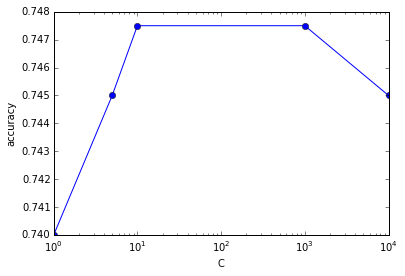

([0.73999999999999999,
  0.745,
  0.74749999999999994,
  0.74750000000000016,
  0.74500000000000011],
 [1.0, 1.0, 1.0, 1.0, 1.0])

In [53]:
# def compare_c(filenames, y, penalty='l2', cs=[.001, .01, .1, 1, 5, 10, 1000, 10000]):
def compare_c(filenames, y, penalty='l2', cs=[1, 5, 10, 1000, 10000]):
    accs = []
    train_accs = []
    # cs = [.00001, .1, 1, 5, 10, 1000]
    for c in cs:
        test_acc, train_acc = do_expt(filenames, y, c=c, penalty=penalty)
        accs.append(test_acc)
        train_accs.append(train_acc)
    plt.figure()
    plt.plot(cs, accs, 'bo-', label='test acc')
    # plt.plot(cs, train_accs, 'go-', label='train acc')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.xscale('log')
    plt.show()
    return accs, train_accs
    
compare_c(filenames, y)

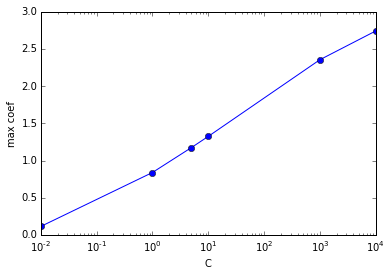

[0.11466026802541229,
 0.83929621603127313,
 1.1744811278974618,
 1.324203134850072,
 2.3546797109082895,
 2.7410768190860462]

In [29]:
def compare_c_coef(X, y, penalty='l2'):
    max_coef = []
    cs = [.01, 1, 5, 10, 1000, 10000]
    for c in cs:
        clf = get_clf(c=c, penalty=penalty)
        clf.fit(X, y)
        max_coef.append(max(np.abs(clf.coef_[0])))
    plt.figure()
    plt.plot(cs, max_coef, 'bo-')
    plt.xlabel('C')
    plt.ylabel('max coef')
    plt.xscale('log')
    plt.show()
    return max_coef
    
compare_c_coef(X, y)

## L1 Regularization

Penalize by absolute value of coefficients (rather than square):

$$
E(D, \theta) = - \prod_{i \in D} p(y_i|x_i) + \frac{1}{C}\sum_k |\theta_k|
$$


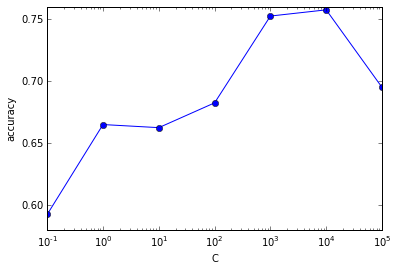

([0.59250000000000003,
  0.66500000000000004,
  0.66249999999999998,
  0.68250000000000011,
  0.75249999999999995,
  0.75750000000000006,
  0.69499999999999995],
 [0.68562500000000004, 0.99937500000000001, 1.0, 1.0, 1.0, 1.0, 1.0])

In [30]:
compare_c(filenames, y, penalty='l1', cs=[.1, 1., 10, 1e2, 1e3, 1e4, 1e5])

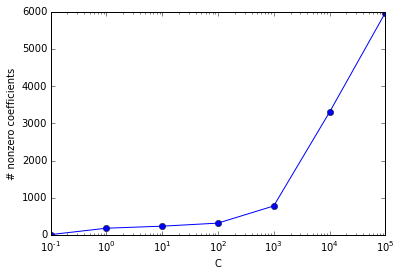

[9, 181, 236, 318, 779, 3300, 5974]

In [31]:
def compare_num_feats(X, y, cs=[.1, 1., 10, 1e2, 1e3, 1e4, 1e5]):
    nnzs = []
    for c in cs:
        clf = get_clf(c=c, penalty='l1')
        clf.fit(X, y)
        nnz = len(np.where(clf.coef_[0]!=0)[0])
        nnzs.append(nnz)
    plt.figure()
    plt.plot(cs, nnzs, 'bo-')
    plt.xlabel('C')
    plt.ylabel('# nonzero coefficients')
    plt.xscale('log')
    plt.show()
    return nnzs
    
compare_num_feats(X, y)

In [57]:
# What features are selected?
def print_top_terms(model, vec, n=10):
    terms = np.array(vec.get_feature_names())
    print '\nTop Coefficients'
    coef = model.coef_[0]
    srted = np.argsort(coef)
    topi = srted[::-1][:n]
    boti = srted[:n]
    print 'Positive Terms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(terms[topi], coef[topi]))
    print '\nNegativeTerms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(terms[boti], coef[boti]))

clf = get_clf(c=.1, penalty='l1')
clf.fit(X, y)
print_top_terms(clf, vec)


Top Coefficients
Positive Terms:
great (0.207907)
best (0.207509)
will (0.112228)
film (0.0667835)
worth (0.0246239)
well (0.00193947)
zucker (0)
fantasy (0)
fare (0)
farcical (0)

NegativeTerms:
worst (-0.726748)
bad (-0.313763)
nothing (-0.299507)
poky (0)
poland (0)
poldark (0)
pole (0)
police (0)
policeman (0)
policies (0)


In [64]:
# How to predict when no features?
clf.intercept_=.1
print(clf.predict_proba([0] * len(vec.vocabulary_)))
print('intercept=%g' % clf.intercept_)

[[ 0.47502081  0.52497919]]
intercept=0.1


In [69]:
clf = get_clf(c=1000, penalty='l1')
clf.fit(X, y)
print(clf.predict_proba([0] * len(vec.vocabulary_)))
print('intercept=%g' % clf.intercept_)
print(Counter(y))

[[ 0.49525703  0.50474297]]
intercept=0.0189725
Counter({0: 200, 1: 200})


## Feature Selection

Rather than using L1 regularization, we can explicitly look for terms that are highly correlated with the class label.

Intuitively, we want terms that are very probable in one class, but not the other.

One way to compute this is the chi-squared statistic: $\chi^2$

The chi-squared statistic is used in hypothesis testing to determine whether two variables are independent.

$$A \perp B \iff P(A,B) \equiv P(A)P(B)$$

To apply this to feature selection, we wish to know whether the occurrence of a term is independent of the class label. 
- If they are independent, then it is not a useful feature. 
- If they are highly dependent, then it is a useful feature.

To compute the chi-squared statistic for term $t$ and class label $y$:

- Let $N^t_{i,j}$ indicate the number of documents that contain/don't contain term $t$ and have class label $y$.
  - E.g., $N^t_{0,0}=10$ means that 10 document have class label $0$ and do **not** have term $t$.
  - E.g., $N^t_{1,1}=10$ means that 10 documents have class label $1$ and do have term $t$.
  
So, for each term we have a table like this:

|         |  y=1          |  y=0         |
|---------|---------------|--------------|
| **t=1** |  $N^t_{11}$   | $N^t_{10}$   |
| **t=0** | $N^t_{01}$    | $N^t_{00}$   |

The chi-squared statistic measures how much these values deviate from what would be expected if $t$ and $y$ were independent.

If $N$ is the total number of documents, then the expected value $E_{11}$ (for $t=1$, $y=1$) is:

$$
p(t=1) = \frac{N^t_{11} + N^t_{10}}{N}
$$

$$
p(y=1) = \frac{N^t_{11} + N^t_{01}}{N}
$$

$$
E_{11} = N * p(t=1) * p(y=1)
$$
Then, the chi-squared statistic is as follows:
$$
\chi^2 = \sum_{ij} \frac{(N^t_{ij} - E^t_{ij})^2}{E^t_{ij}}
$$



In [125]:
from sklearn.feature_selection import chi2

chi, pvals = chi2(X,y)

In [126]:
feats = vec.get_feature_names()
# Top chi-sq terms:
for i in np.argsort(chi)[::-1][:10]:
    print('index=%d chisq=%.2f %s' % (i, chi[i], feats[i]))

index=10577 chisq=29.88 worst
index=10344 chisq=20.00 waste
index=9472 chisq=16.13 terrible
index=6497 chisq=16.07 nothing
index=10578 chisq=15.21 worth
index=1216 chisq=14.44 boring
index=869 chisq=13.79 bad
index=9244 chisq=13.00 superb
index=837 chisq=12.57 awful
index=7157 chisq=12.57 poor


In [127]:
# Bottom chi-sq terms:
for i in np.argsort(chi)[:10]:
    print('index=%d chisq=%.2f %s' % (i, chi[i], feats[i]))

index=3401 chisq=0.00 excitement
index=6069 chisq=0.00 military
index=7624 chisq=0.00 realized
index=798 chisq=0.00 australia
index=4779 chisq=0.00 important
index=796 chisq=0.00 austen
index=2068 chisq=0.00 confronted
index=5536 chisq=0.00 li
index=794 chisq=0.00 aussie
index=4103 chisq=0.00 glaring


In [111]:
# How many times does "worst" appear?
X.sum(axis=0).A1[10577]

41

In [131]:
# What labels do the documents containing "worst" have?
Counter(y[np.where(X[:, 10577].T.toarray()[0]==1)])
# Clearly skewed toward negative class, so high chisq value.

Counter({0: 38, 1: 3})

In [129]:
# How many times does "excitement" appear?
X.sum(axis=0).A1[3401]

4

In [130]:
# What labels do the documents containing "excitement" have?
Counter(y[np.where(X[:, 3401].T.toarray()[0]==1)])
# Equally distributed between classes, so chisq=0

Counter({0: 2, 1: 2})